# Double Deep Q-Network (DQN) for LunarLander-v2

This notebook is an implementation of a Double Deep Q-Network to tackle the "LunarLander-v2" environment in OpenAI Gym. The Double DQN will learn to land a spacecraft safely on the lunar surface. The goal is to achieve an average score of 195 or above over the last 50 episodes.

## Import Libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import os
import renderlab
import itertools

## Setting Up the Environment

Initializing the LunarLander-v2 environment and determining the state and action sizes.

In [2]:
# Initialize the Lunar Lander environment
env = gym.make('LunarLander-v2')
# Get the size of the state space
state_size = env.observation_space.shape[0]  
# Get the number of actions available
action_size = env.action_space.n  

## Defining Hyperparameters and Variables

In [3]:
# Define the Parameters

# Discount factor for future rewards
GAMMA = 0.99  
# Size of the batch used in learning
BATCH_SIZE = 128 
# Maximum size of the replay buffer
BUFFER_SIZE = 10000  
# Starting value of epsilon for the epsilon-greedy policy
EPS_START = 1.0 
# Minimum value of epsilon for the epsilon-greedy policy
EPS_END = 0.01
# Decay rate of epsilon per episode
EPS_DECAY = 0.995  
# Learning rate for the neural network optimizer
LEARNING_RATE = 0.0005  

# Define the Variables

# Threshold score for considering the environment solved
solved_score = 195
# List to keep track of total reward per episode
scores = []  
# List to keep track of average score over the last 50 episodes
average_scores = []  
# Maximum steps per episode to prevent very long episodes
max_steps_per_episode = 2000 
# Flag to indicate whether the environment is solved
solved = False 

## Setting Up Model Saving Paths

Defining and preparing the file paths for saving the trained model and average score data. 

In [4]:
# Define the path where the trained model will be saved
model_save_path = 'models/double_dqn_lunarlander_model.pth'

# Extract the directory path from the model save path
model_directory = os.path.dirname(model_save_path)
# Check if the directory exists
if not os.path.exists(model_directory):
    # If the directory does not exist, create it
    os.makedirs(model_directory)
    
# Define the path for saving average score data
folder_path = 'average_scores/'

# Check if the directory for average scores exists
if not os.path.exists(folder_path):
    # If the directory does not exist, create it
    os.makedirs(folder_path)

## Defining the Double DQN Model

Defining the neural network architecture for the Double DQN agent

In [5]:
class DOUBLE_DQN(nn.Module):
    # The constructor of the DOUBLE_DQN class, inheriting from nn.Module
    def __init__(self, state_size, action_size):
        # Initialize the superclass
        super(DOUBLE_DQN, self).__init__()
        
        # Define the first fully connected layer
        # It takes the state size as input and outputs 64 features
        self.fc1 = nn.Linear(state_size, 64)

        # Define the second fully connected layer
        # It takes the 64 features from the previous layer and outputs 64 features
        self.fc2 = nn.Linear(64, 64)

        # Define the third fully connected layer
        # It takes the 64 features from the previous layer and outputs the number of actions
        self.fc3 = nn.Linear(64, action_size)

    # The forward pass of the network
    def forward(self, x):
        # Apply a ReLU activation function after the first fully connected layer
        x = F.relu(self.fc1(x))
        # Apply a ReLU activation function after the second fully connected layer
        x = F.relu(self.fc2(x))
        # The final layer outputs the Q-values for each action
        return self.fc3(x)

## Implementing Replay Memory

Implementing a replay buffer to store and sample experiences for training the Double DQN agent.

In [6]:
# Define a namedtuple to store the experience tuples
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    # Constructor for ReplayMemory class
    def __init__(self, capacity):
        # Initialize a double-ended queue with a fixed maximum size (capacity)
        # This deque will store the transitions
        self.memory = deque([], maxlen=capacity)

    # Method to push a new transition into the memory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Method to randomly sample a batch of transitions from the memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # Method to return the length of the memory
    def __len__(self):
        return len(self.memory)

## Creating the Double DQN Agent

Creating a class for the Double DQN agent encapsulating action selection, model updates, and interaction with replay memory.

In [7]:
class Double_DQNAgent:
    # Constructor for the double DQN Agent
    def __init__(self, state_size, action_size):
        # Initialize the state and action sizes
        self.state_size = state_size
        self.action_size = action_size
        # Set the initial exploration rate for epsilon-greedy strategy
        self.epsilon = EPS_START

        # Initialize the policy and target networks for Double DQN
        self.policy_net = DOUBLE_DQN(state_size, action_size)
        self.target_net = DOUBLE_DQN(state_size, action_size)

        # Copy weights from policy network to target network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # Set the target_net to evaluation mode
        self.target_net.eval()  

        # Optimizer for updating policy network weights
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        # Replay memory for storing experiences
        self.memory = ReplayMemory(BUFFER_SIZE)

    # Method to select an action based on the current state
    def select_action(self, state):
        # Random sample for epsilon-greedy strategy
        sample = random.random()  
        # Current value of epsilon
        eps_threshold = self.epsilon  
        # Epsilon-greedy policy: choose best action or random action
        if sample > eps_threshold:
            # Disable gradient calculation
            with torch.no_grad():  
                # Choose the action with the highest Q-value for the current state
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            # Choose a random action
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long)
    
    # Method to optimize the model (update the policy network)
    def optimize_model(self):
        # Do not proceed if not enough samples in memory
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample a batch of experiences from memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Separate non-final and final states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        # Get Q values for current state-action pairs
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Double DQN Logic: 
        # Use the policy net to select the best action for next states
        next_state_actions = self.policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
        # Use the target net to calculate the Q value of these actions
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, next_state_actions).squeeze(1)

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) * (1 - done_batch) + reward_batch

        # Compute the loss between current Q values and expected Q values
        loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        # Zero gradients before backward pass
        self.optimizer.zero_grad()
        # Backward pass to compute gradients
        loss.backward()
        # Update the weights of the policy network
        self.optimizer.step()

    def update_target_net(self):
        # Update the target network with the policy network's weights
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        # Decay the exploration rate
        self.epsilon = max(EPS_END, EPS_DECAY * self.epsilon)
        
# Instantiate the Double DQN agent
agent = Double_DQNAgent(state_size, action_size)

## The Training Loop

Running the training process for the agent, including interacting with the environment, optimizing the model, and tracking progress.

In [8]:
# Training loop (Iterate over episodes indefinitely or until solved)
for i_episode in itertools.count(): 
    # Reset environment and get initial state
    state_tuple = env.reset()  
    state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
    # Convert to torch tensor
    state = torch.from_numpy(state).float().unsqueeze(0)  
    # Initialize total reward for this episode
    total_reward = 0  
    # Flag to track if the episode has ended
    done = False  
    # Count the number of steps in the episode
    step_count = 0  

    while not done and step_count < max_steps_per_episode:
        # Select an action
        action = agent.select_action(state)  
        # Apply action to environment
        output = env.step(action.item())  
        # Unpack results
        next_state, reward, done = output[0], output[1], output[2]  

        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward_tensor = torch.tensor([reward], dtype=torch.float)

        # Store experience in replay memory
        agent.memory.push(state, action, next_state, reward_tensor, done)
        # Update state
        state = next_state 
        # Accumulate reward
        total_reward += reward  

        # Optimize the model
        agent.optimize_model()
        step_count += 1

    # Update target network and decay epsilon
    agent.update_target_net()
    agent.decay_epsilon()

    # Store the total reward
    scores.append(total_reward)

    # Calculate and store the average score of the last 50 episodes
    if len(scores) >= 50:
        # Compute the average score of the most recent 50 episodes
        avg_score_last_50 = np.mean(scores[-50:])
        # Add this average to the list
        average_scores.append(avg_score_last_50) 

        # Check if the environment is considered solved
        # The environment is solved if the average score is >= 195 for the last 50 episodes
        if avg_score_last_50 >= solved_score and not solved:
            print("*"*125)
            print(f"Solved at episode: {i_episode} - Average score over the last 50 episodes: {avg_score_last_50}")
            # Save the current state of the policy network for future use or evaluation
            torch.save(agent.policy_net.state_dict(), model_save_path)
            print("*"*125)
            # Update the flag to indicate the task is solved
            solved = True  
            # Exit from the training loop as the goal is achieved
            break  

    # Output progress every 10 episodes
    if i_episode % 10 == 0:
        # Calculate the average score of the last 10 episodes for more frequent updates
        # If fewer than 10 scores are available, calculate the average of all available scores
        avg_score_last_10 = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
        # Print the recent performance every 10 episodes for monitoring progress
        print(f"Episode {i_episode}, Average Score Last 10 Episodes: {avg_score_last_10}")
        
# Save the average scores for analysis
np.save(folder_path + 'average_scores_double.npy', average_scores)    

# Close the environment
env.close()

Episode 0, Average Score Last 10 Episodes: -294.68429443752706
Episode 10, Average Score Last 10 Episodes: -278.88232983662505
Episode 20, Average Score Last 10 Episodes: -130.67346644726763
Episode 30, Average Score Last 10 Episodes: -142.0377686720319
Episode 40, Average Score Last 10 Episodes: -123.87481119543142
Episode 50, Average Score Last 10 Episodes: -115.87874720625591
Episode 60, Average Score Last 10 Episodes: -85.70435625025907
Episode 70, Average Score Last 10 Episodes: -62.1218038805692
Episode 80, Average Score Last 10 Episodes: -80.62217587215952
Episode 90, Average Score Last 10 Episodes: -61.173095381675445
Episode 100, Average Score Last 10 Episodes: -59.37790006954134
Episode 110, Average Score Last 10 Episodes: -35.20464873515686
Episode 120, Average Score Last 10 Episodes: -57.310734221942155
Episode 130, Average Score Last 10 Episodes: -44.083940772963885
Episode 140, Average Score Last 10 Episodes: -42.88401762856446
Episode 150, Average Score Last 10 Episodes:

## Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

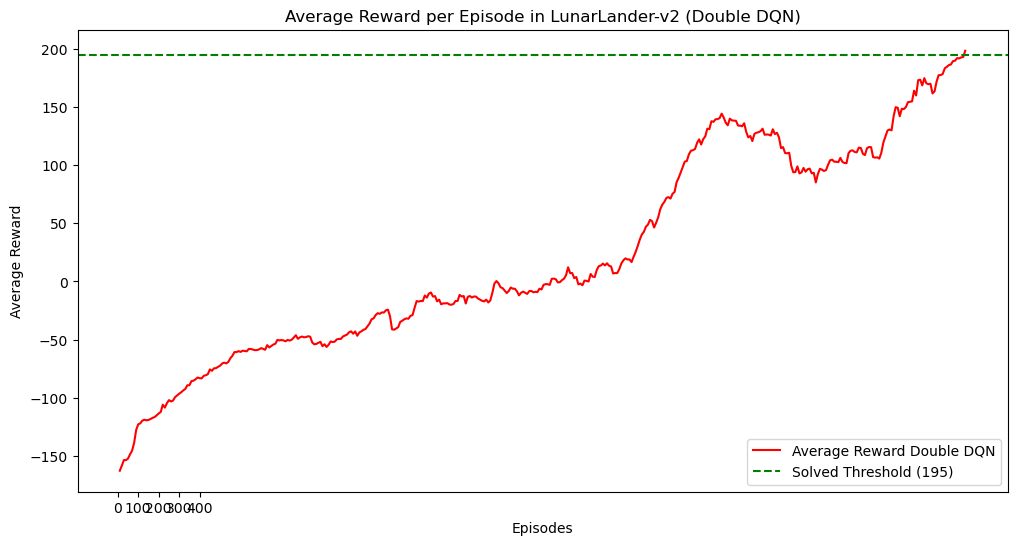

In [9]:
# Creating the plot

# Generate a range of episode numbers for the x-axis
# Start from episode 10 and increment by 10 until the number of episodes recorded
episode_numbers = list(range(10, len(average_scores) * 10 + 1, 10))

plt.figure(figsize=(12, 6))

# Plot average rewards per episode
plt.plot(episode_numbers, average_scores, label='Average Reward Double DQN', color='red')

# Add a horizontal line representing the solved threshold
plt.axhline(y=solved_score, color='green', linestyle='--', label='Solved Threshold (195)')

# Set x-axis labels to show every 100 episodes
plt.xticks(range(0, len(average_scores) + 1, 100))

# Set labels for x and y axes
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

# Display the plot
plt.title('Average Reward per Episode in LunarLander-v2 (Double DQN)')
plt.legend()
plt.show()